# Density comparison

Here we consider how `den-` impacts surfaces
Note that ideally the density should roughly correspond to the data resolution, so you are adequately but not overlsampling the image!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import art3d
import nibabel as nib
import hippomaps as hm

/export03/data/opt/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
subfields = nib.load(f'{hm.__path__[0]}/../resources/parc-multihist7/sub-0_hemi-0_space-0_den-0p5mm_label-hipp_atlas-multihist7_subfields.label.gii').darrays[0].data
subfields_2mm = hm.utils.density_interp('0p5mm','2mm',subfields,'hipp',method='nearest')[0]

In [3]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale.  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.
    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().'''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
    return ax


In [4]:
def cdata_vertex_to_face(c,faces):
    '''Interpolates vertex data to the nearest face
    Input
      c: vertex data
      faces: face data'''
    if len(c.shape)>1:
        cf = np.zeros([len(faces),c.shape[1]])
        for f in range(len(faces)):
            cf[f,:] = np.mean(c[faces[f],:],axis=0)
    else:
        cf = np.zeros(len(faces))
        for f in range(len(faces)):
            cf[f] = np.mean(c[faces[f]])
    return cf

In [5]:
def surfplot_cdata(ax,cdat,f,v,cwindow=False,cmap=False):
    '''create surface in existing axis
    Input
      ax: axis (of type subplot_kw={'projection': "3d"})
      cdata: color of surface
      f: faces
      v: vertices
      cwindow: whether to narrow the window of cdata [True,False, or Tuple for custom window]
      cmap: whether to use a custom colormap [Nx3 where N is the number of unique cdat values]'''
    cdata = cdata_vertex_to_face(cdat,f).astype(int)
    # make window if needed
    if type(cwindow) == type(True):
        if not cwindow:
            norm = plt.Normalize(np.min(cdata), np.max(cdata)) 
        elif cwindow: # use default
            norm = plt.Normalize(window_cdata(cdata)[0],window_cdata(cdata)[1]) 
    else: # hard set window
        norm = plt.Normalize(cwindow[0],cwindow[1]) 
    # set colours if needed
    if type(cmap) == type(False):
        colors = plt.cm.viridis(norm(cdata))
    else:
        colors = np.zeros([len(cdat),cmap.shape[1]])
        u,i = np.unique(cdat,return_index=True)
        for ii in range(len(u)):
            colors[cdat==u[ii],:] = cmap[ii,:]
        colors = cdata_vertex_to_face(colors,f)
    
    pc = art3d.Poly3DCollection(v[f], facecolors=colors, edgecolors=[1,1,1,1], linewidths=(5,))
    ax.add_collection(pc)

    ax.set_xlim([np.min(v[:,0]),np.max(v[:,0])])
    ax.set_ylim([np.min(v[:,1]),np.max(v[:,1])])
    ax.set_zlim([np.min(v[:,2]),np.max(v[:,2])])
    ax.view_init(elev=90, azim=-90)
    ax = set_axes_equal(ax)
    ax.set_axis_off()
    return ax

In [6]:
def plotwire(ax,f,v):
    pc = art3d.Poly3DCollection(v[f], facecolor=[0, 0, 0, 0], edgecolor=[0,0,0,1])
    ax.add_collection(pc)
    ax.set_xlim([np.min(v[:,0]),np.max(v[:,0])])
    ax.set_ylim([np.min(v[:,1]),np.max(v[:,1])])
    ax.set_zlim([np.min(v[:,2]),np.max(v[:,2])])
    ax.view_init(elev=90, azim=-90)
    ax = set_axes_equal(ax)
    ax.axis('off')
    return ax

/data/mica1/01_programs/tmp/ipykernel_13121/2028381535.py:6: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([np.min(v[:,2]),np.max(v[:,2])])


<Axes3D: >

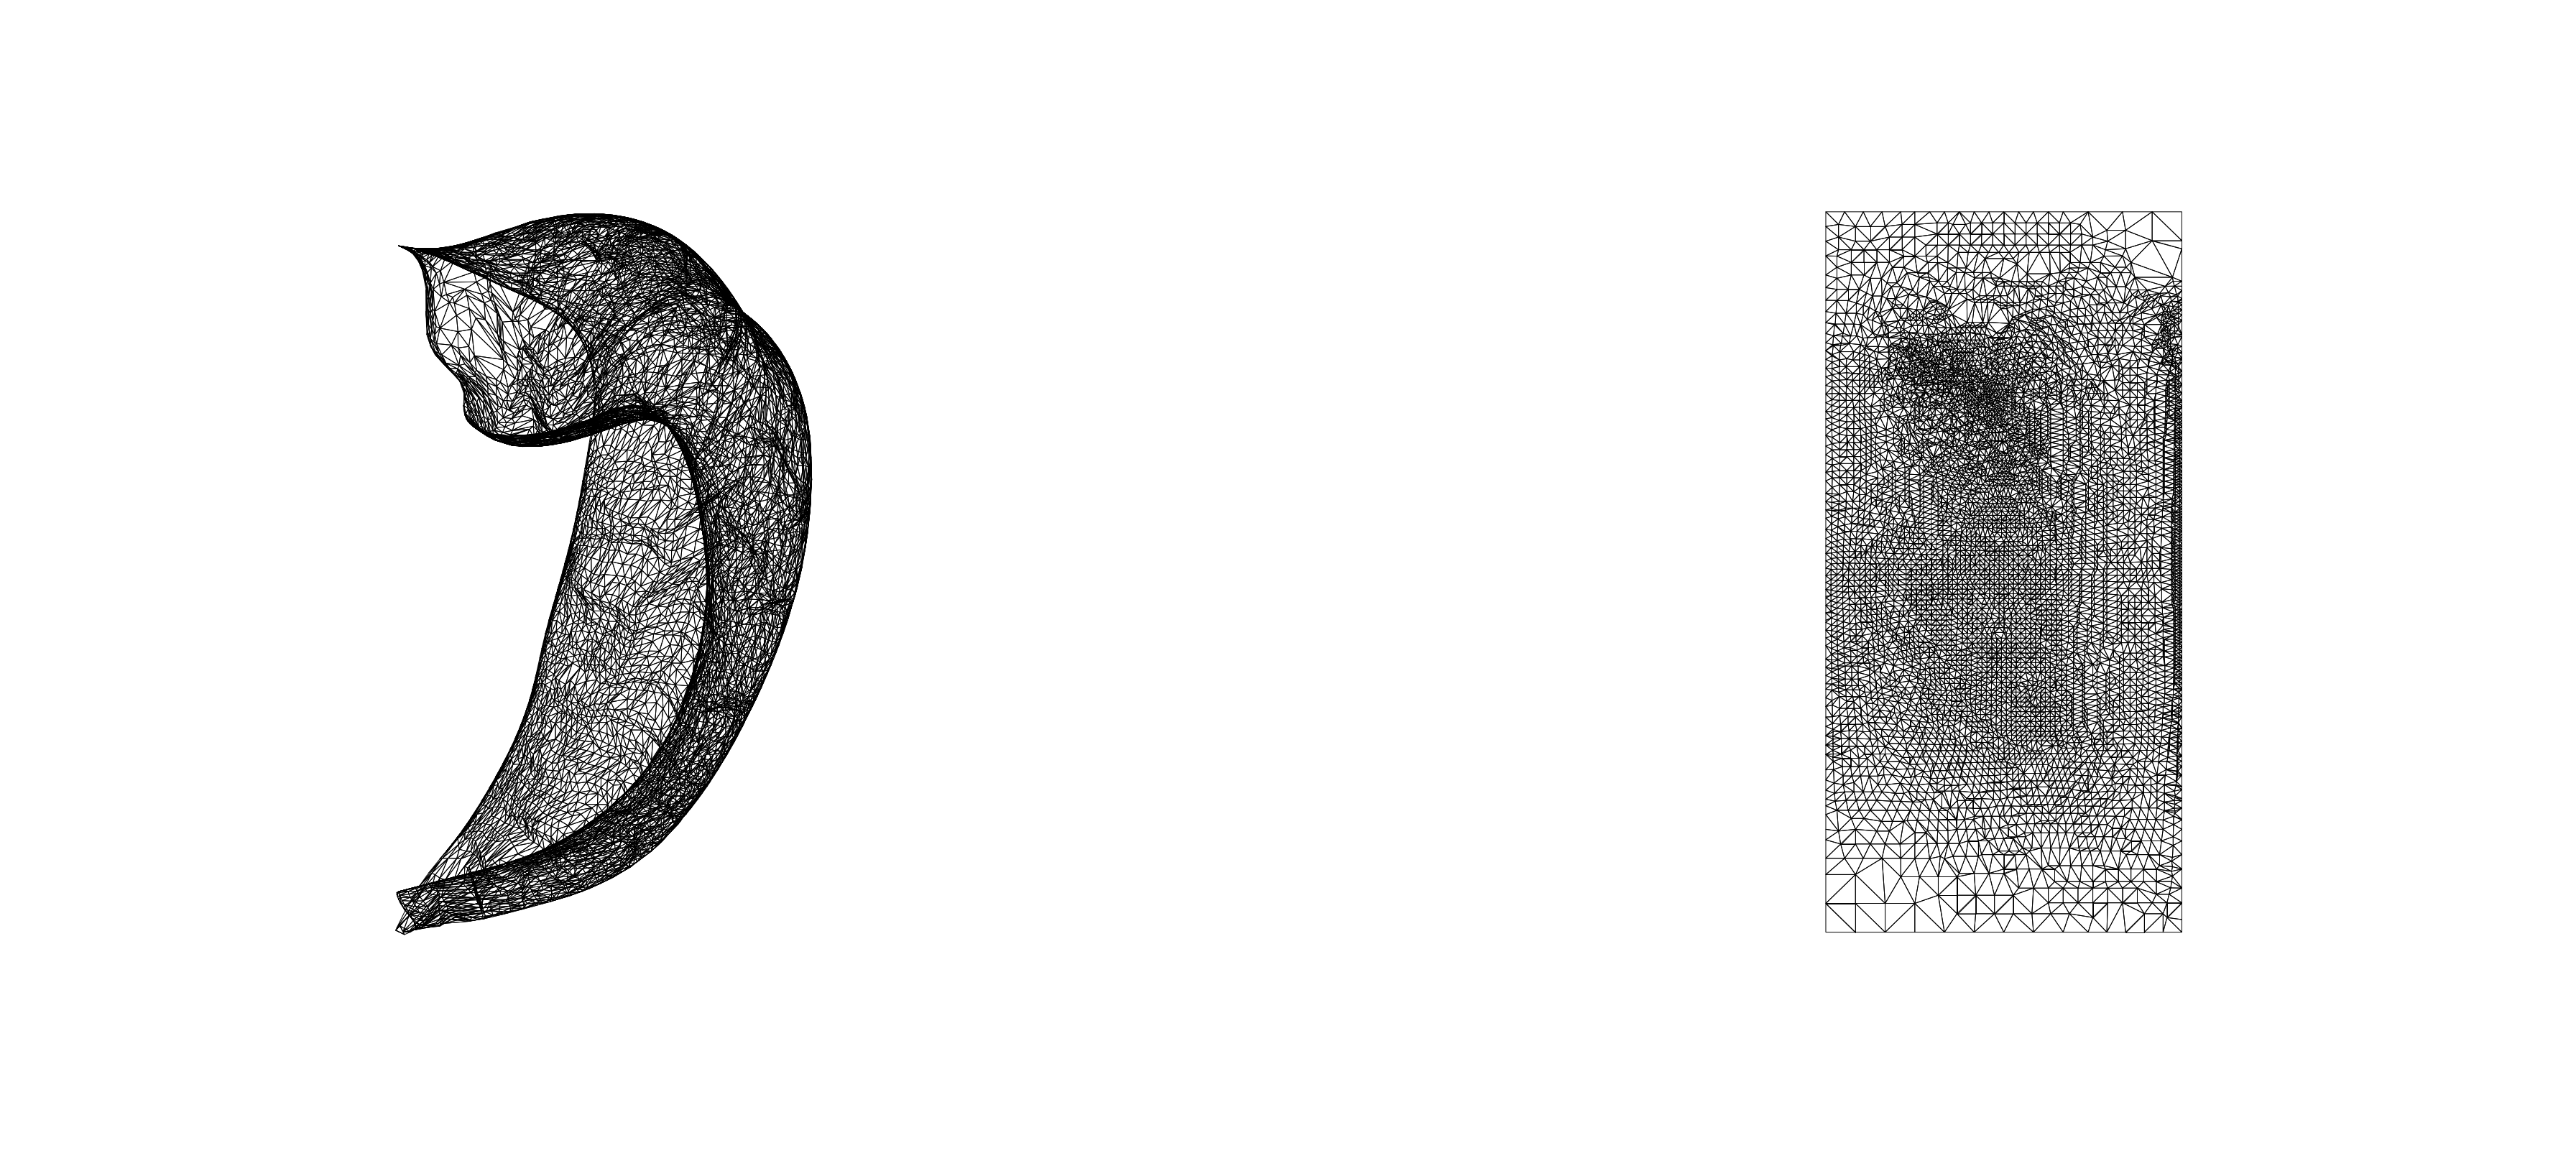

In [7]:
resourcesdir = '/export03/data/opt/hippunfold_toolbox/resources'
den = '0p5mm'

# load canonical and unfolded surfaces
gii = nib.load(f'{resourcesdir}/canonical_surfs/tpl-avg_space-canonical_den-{den}_label-hipp_midthickness.surf.gii')
v = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
f = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
gii = nib.load(f'{resourcesdir}/canonical_surfs/tpl-avg_space-unfold_den-{den}_label-hipp_midthickness.surf.gii')
vu = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data

# reorient unfolded
vu = vu[:,[1,0,2]]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(64,64), subplot_kw={'projection': "3d"})
plotwire(ax[0],f,v)
plotwire(ax[1],f,vu)

/data/mica1/01_programs/tmp/ipykernel_13121/2028381535.py:6: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([np.min(v[:,2]),np.max(v[:,2])])


<Axes3D: >

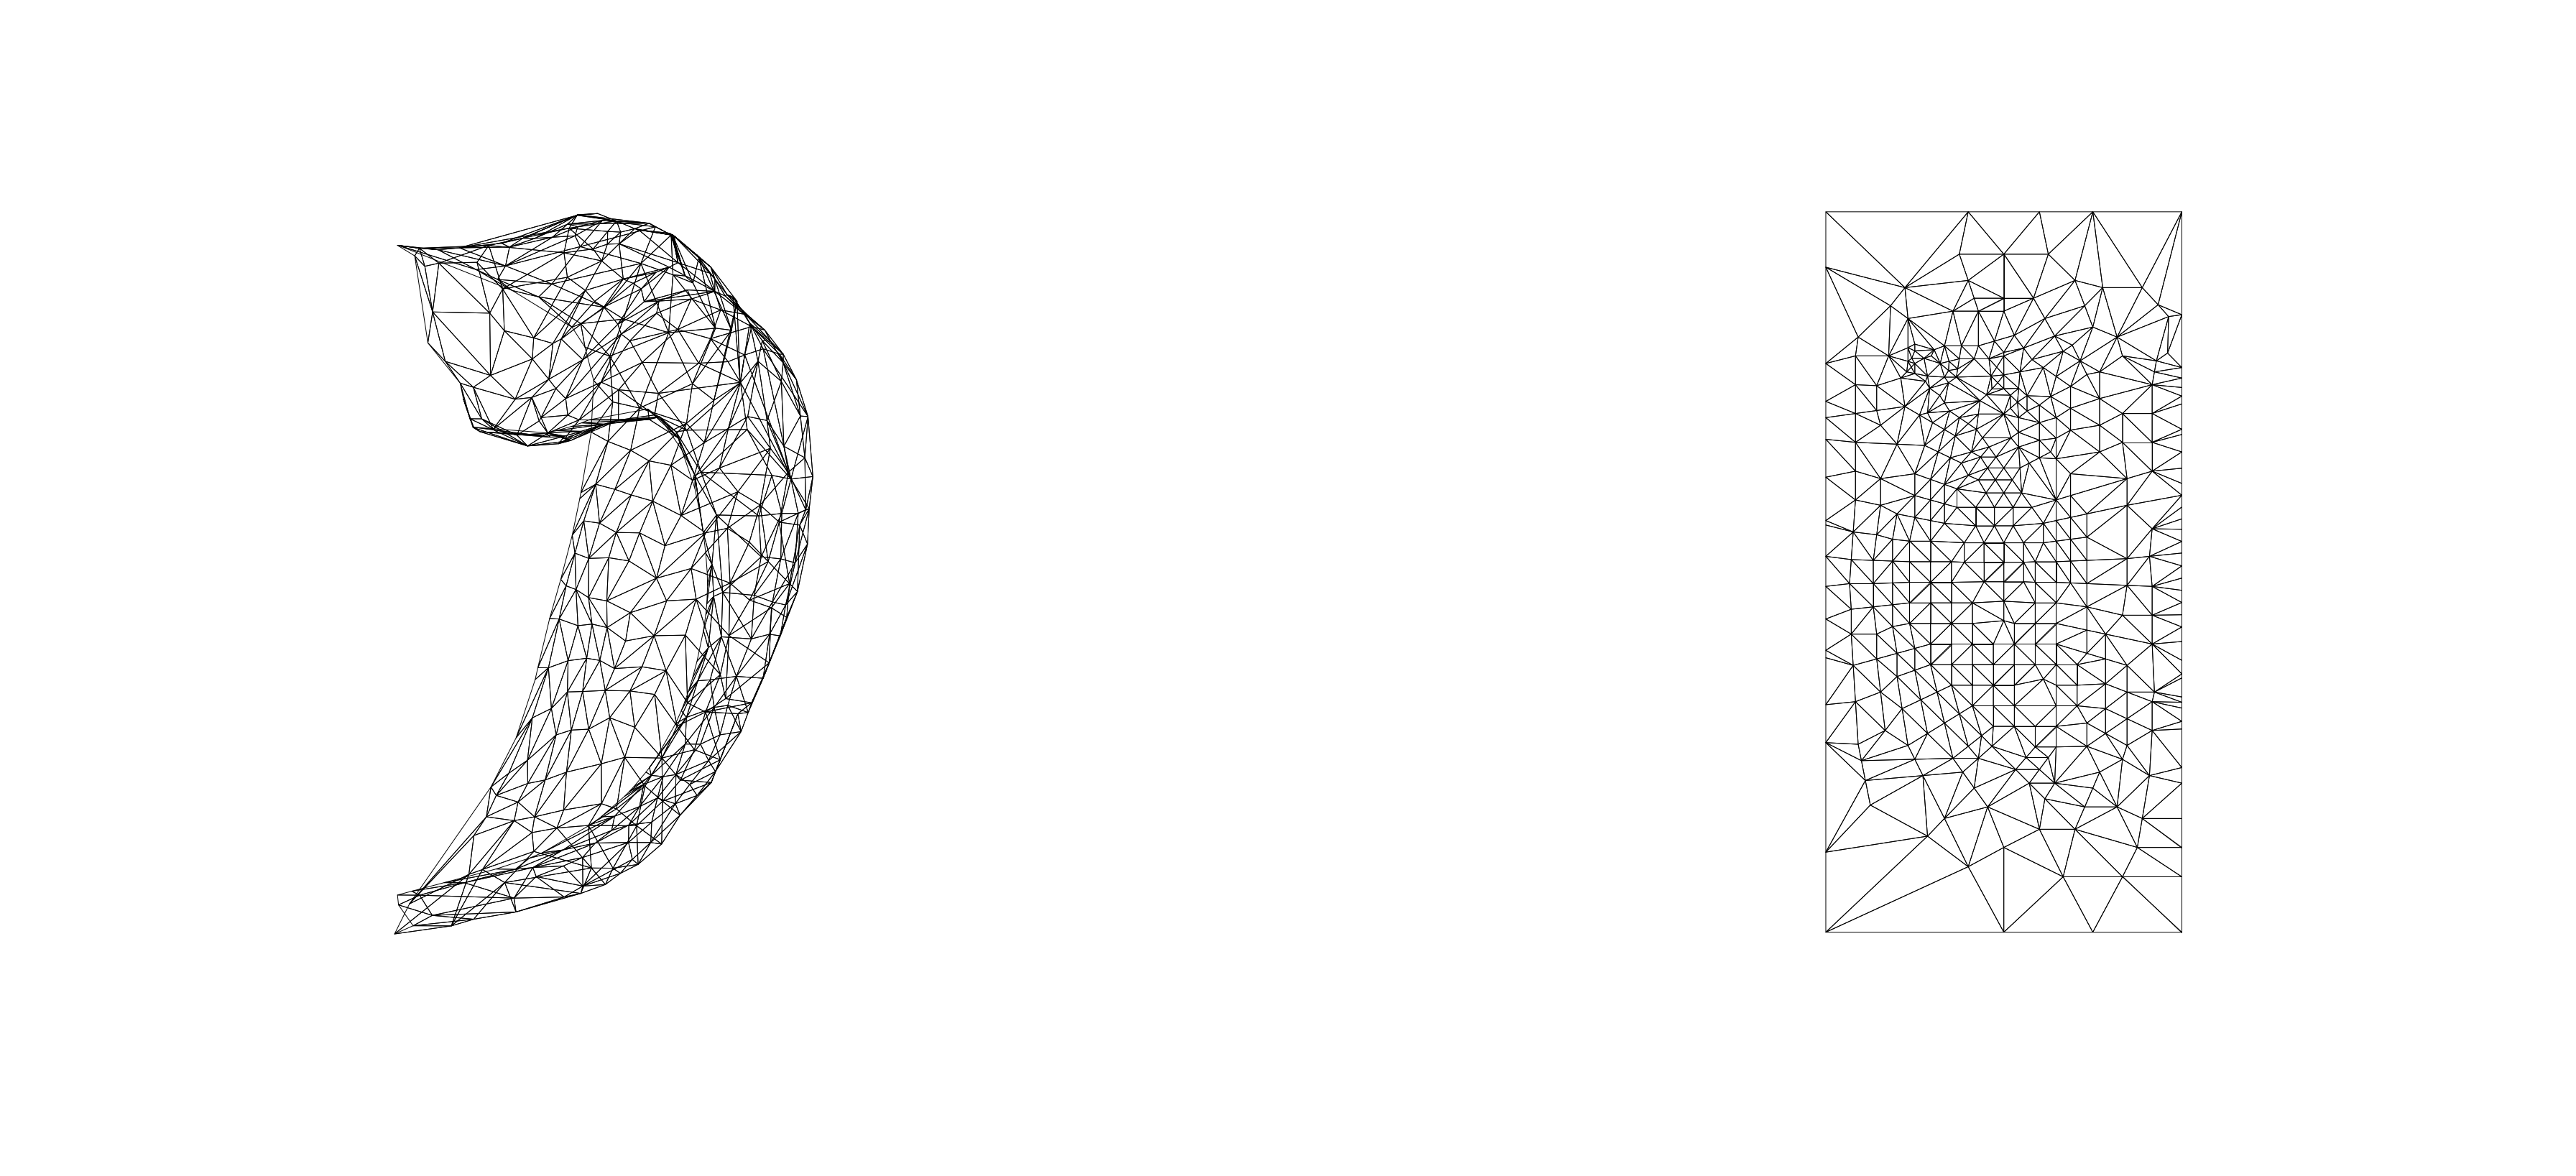

In [8]:
resourcesdir = '/export03/data/opt/hippunfold_toolbox/resources'
den = '2mm'

# load canonical and unfolded surfaces
gii = nib.load(f'{resourcesdir}/canonical_surfs/tpl-avg_space-canonical_den-{den}_label-hipp_midthickness.surf.gii')
v = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
f = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
gii = nib.load(f'{resourcesdir}/canonical_surfs/tpl-avg_space-unfold_den-{den}_label-hipp_midthickness.surf.gii')
vu = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data

# reorient unfolded
vu = vu[:,[1,0,2]]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(64,64), subplot_kw={'projection': "3d"})
plotwire(ax[0],f,v)
plotwire(ax[1],f,vu)

/data/mica1/01_programs/tmp/ipykernel_13121/2427650120.py:34: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([np.min(v[:,2]),np.max(v[:,2])])


<Axes3D: >

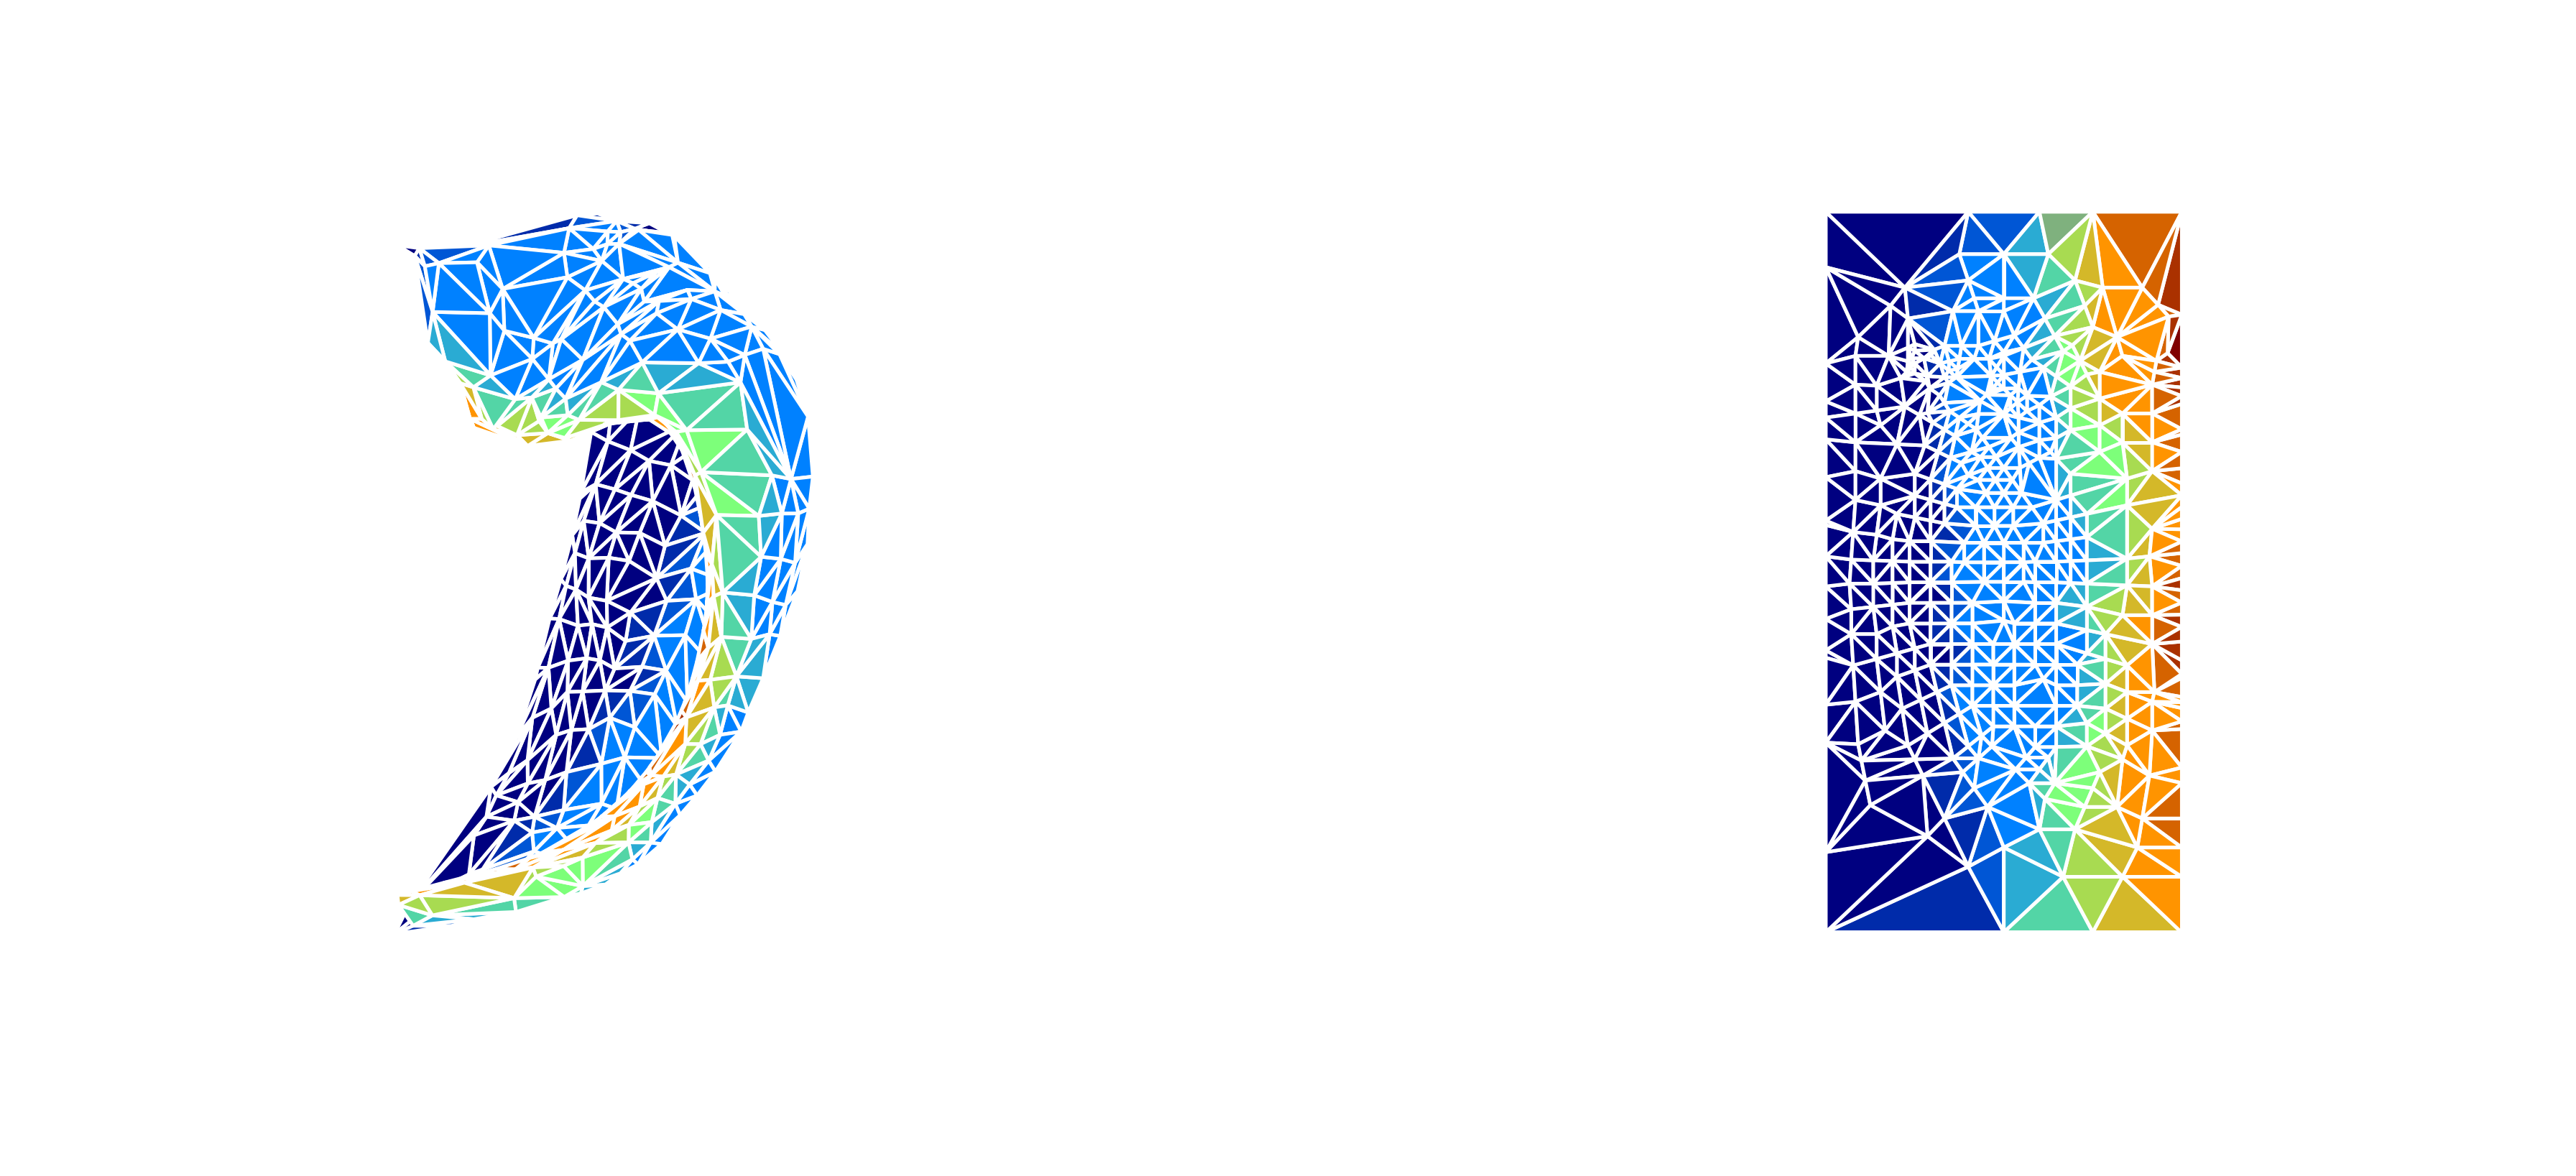

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(64,64), subplot_kw={'projection': "3d"})
surfplot_cdata(ax[0],subfields_2mm,f,v,cwindow=False,cmap=plt.cm.jet(np.linspace(0,1,5)))
surfplot_cdata(ax[1],subfields_2mm,f,vu,cwindow=False,cmap=plt.cm.jet(np.linspace(0,1,5)))

/data/mica1/01_programs/tmp/ipykernel_13121/2028381535.py:6: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([np.min(v[:,2]),np.max(v[:,2])])


<Axes3D: >

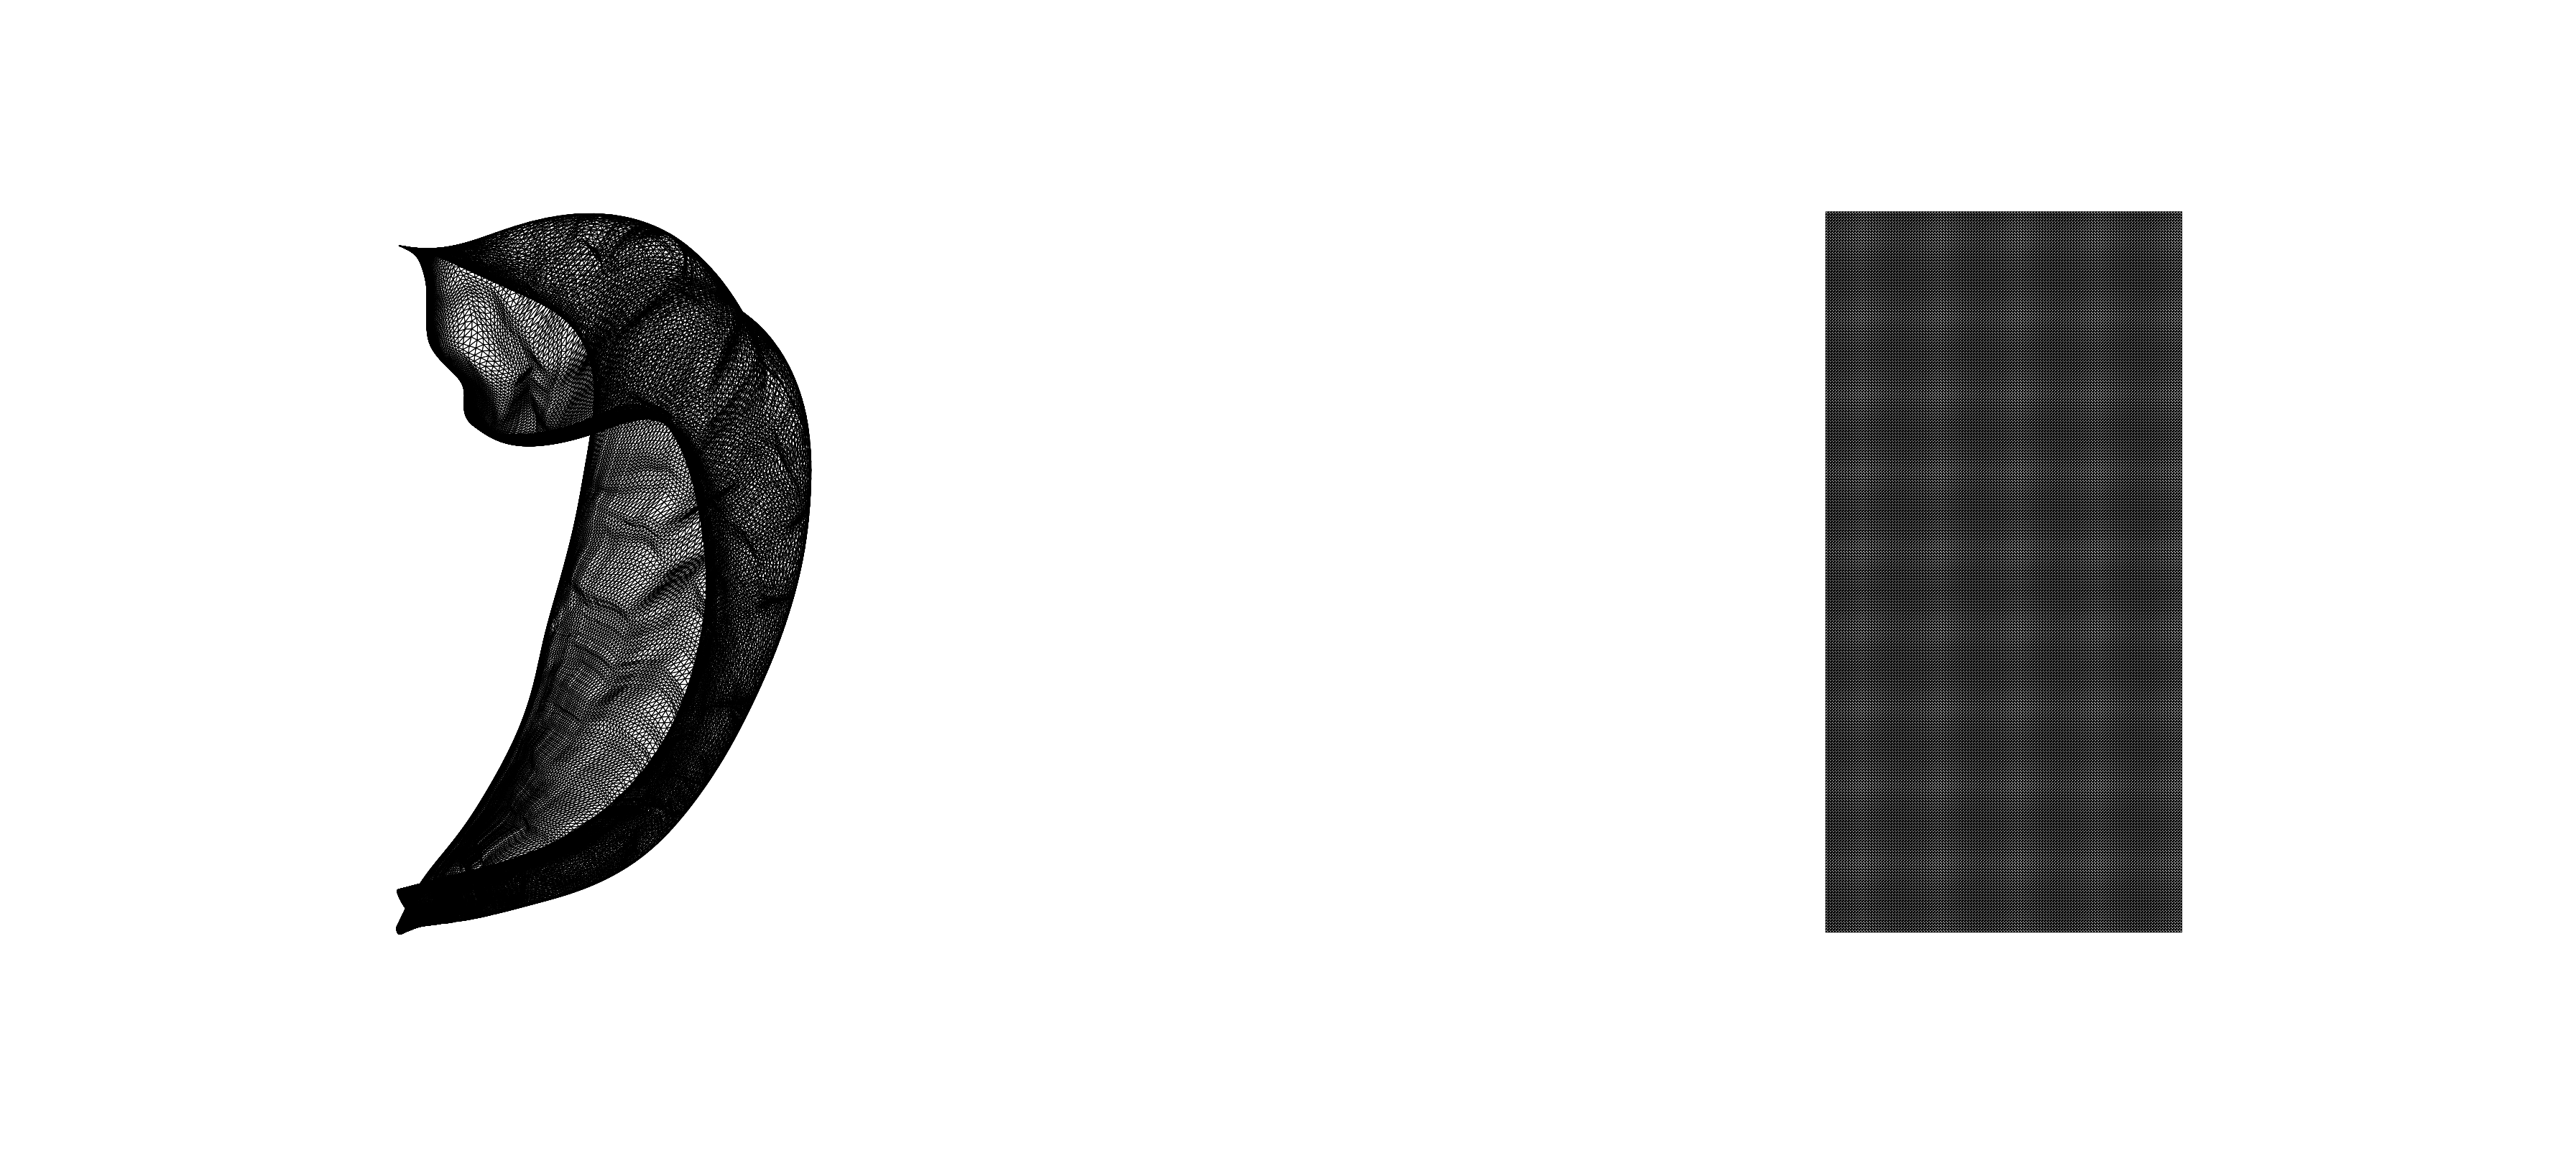

In [10]:
resourcesdir = '/export03/data/opt/hippunfold_toolbox/resources'
den = 'unfoldiso'

# load canonical and unfolded surfaces
gii = nib.load(f'{resourcesdir}/canonical_surfs/tpl-avg_space-canonical_den-{den}_label-hipp_midthickness.surf.gii')
v = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
f = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
gii = nib.load(f'{resourcesdir}/canonical_surfs/tpl-avg_space-unfold_den-{den}_label-hipp_midthickness.surf.gii')
vu = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data

# reorient unfolded
vu = vu[:,[1,0,2]]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(64,64), subplot_kw={'projection': "3d"})
plotwire(ax[0],f,v)
plotwire(ax[1],f,vu)

## now with some real data

/data/mica1/01_programs/tmp/ipykernel_13121/2028381535.py:6: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([np.min(v[:,2]),np.max(v[:,2])])


<Axes3D: >

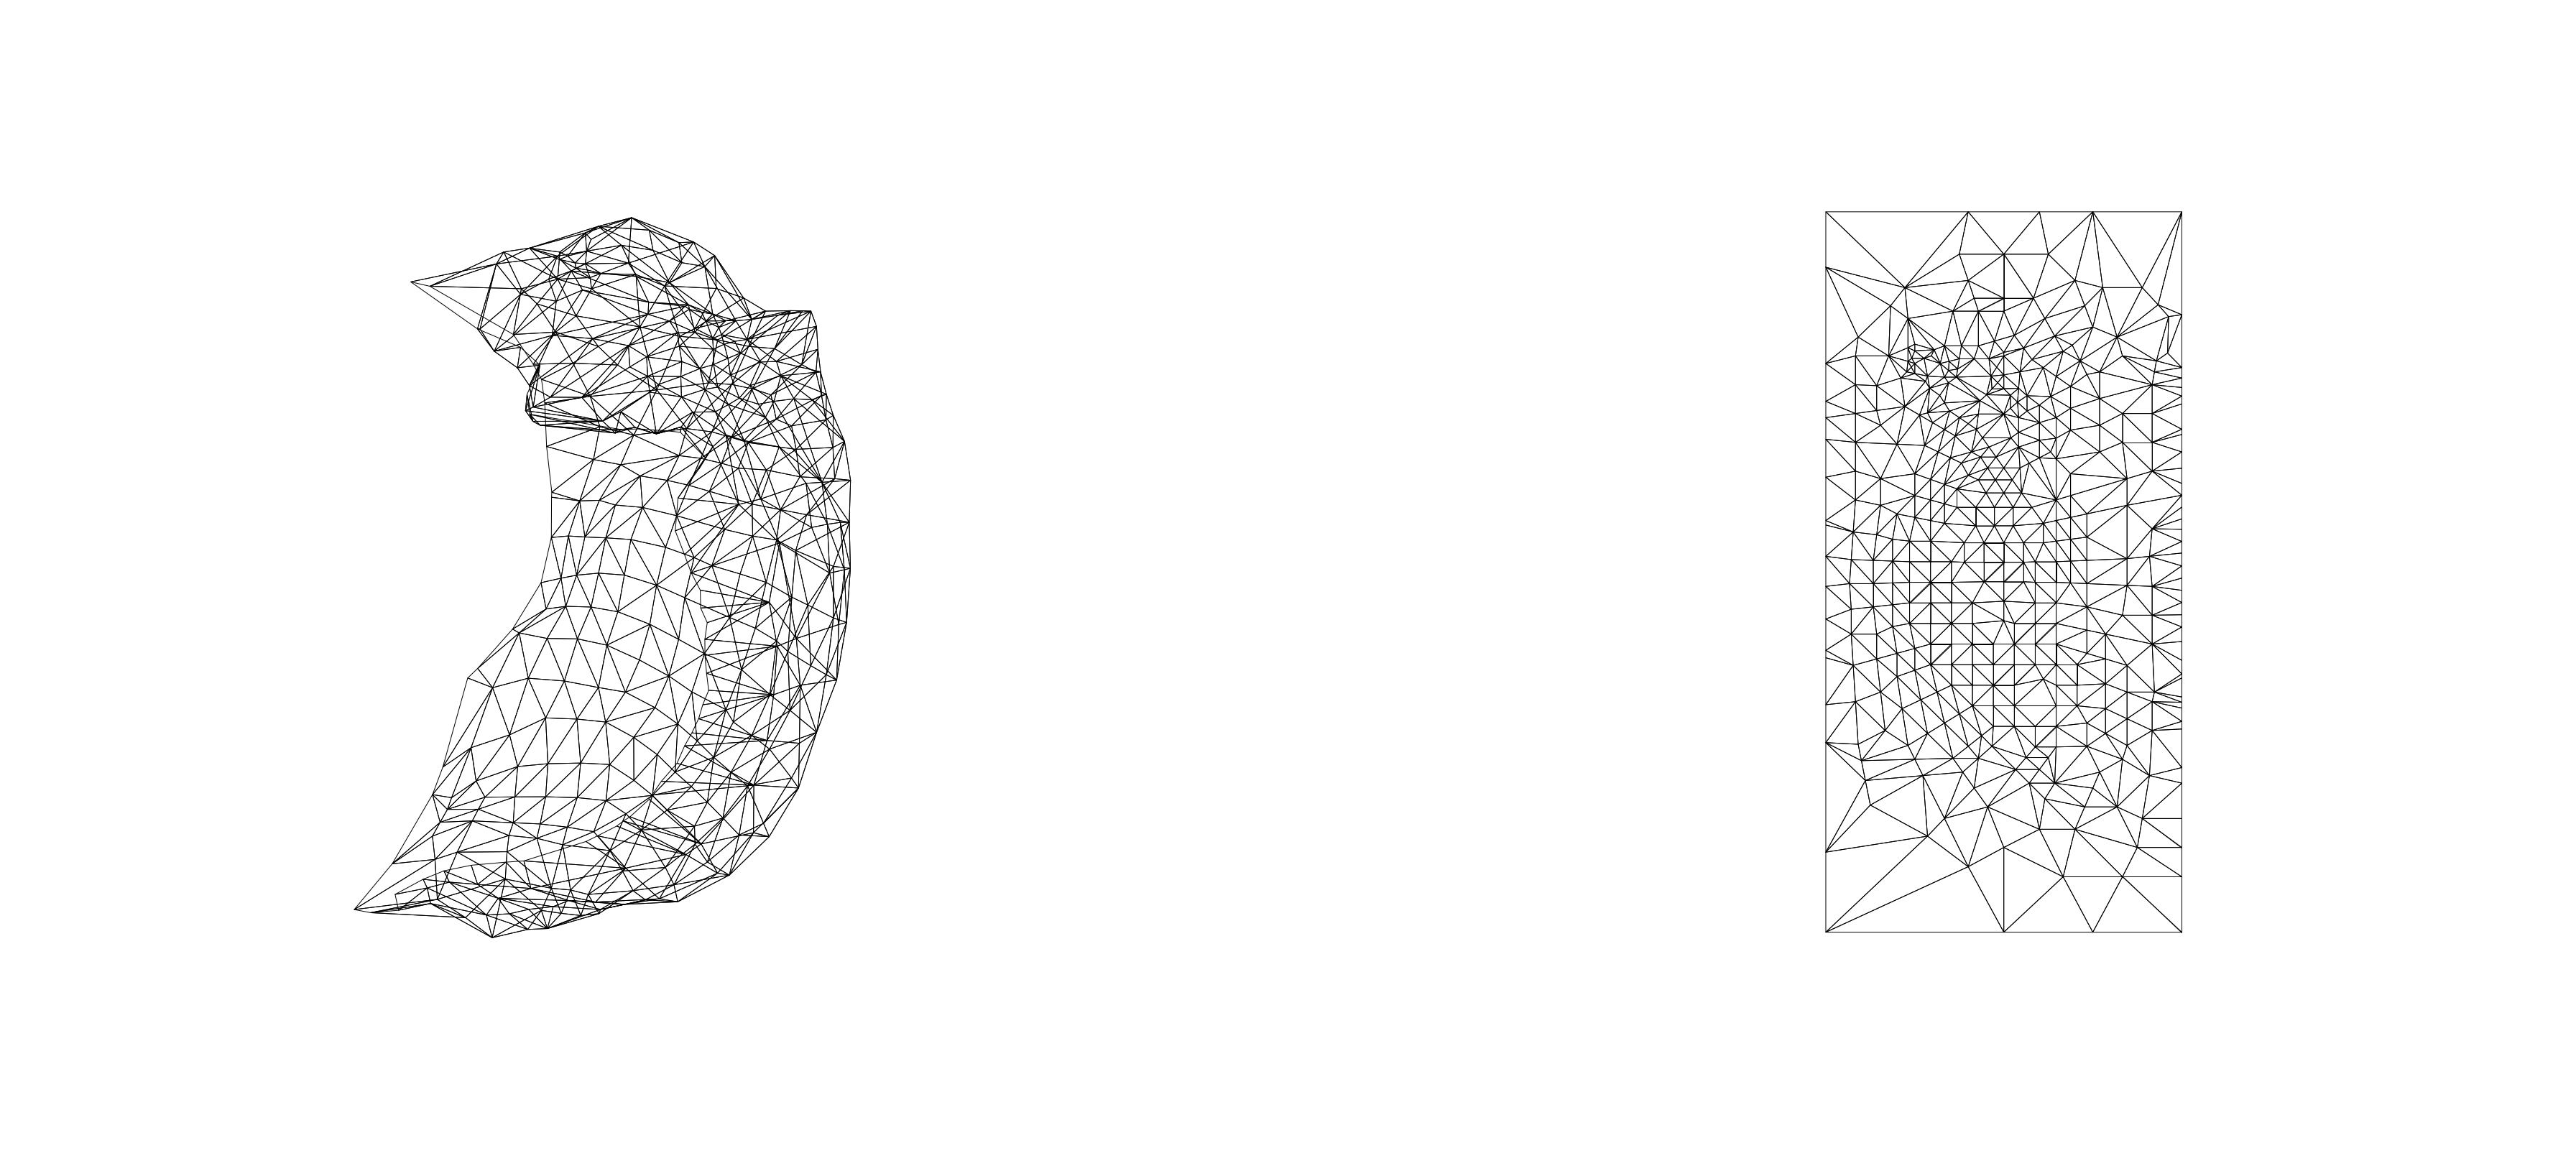

In [11]:
den='2mm'

gii = nib.load('/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold/sub-HC002/ses-01/surf/sub-HC002_ses-01_hemi-R_space-T1w_den-2mm_label-hipp_midthickness.surf.gii')
v = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
f = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
gii = nib.load(f'{resourcesdir}/canonical_surfs/tpl-avg_space-unfold_den-{den}_label-hipp_midthickness.surf.gii')
vu = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
gii = nib.load(f'{resourcesdir}/canonical_surfs/tpl-avg_space-unfold_den-{den}_label-dentate_midthickness.surf.gii')

# reorient unfolded
vu = vu[:,[1,0,2]]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(64,64), subplot_kw={'projection': "3d"})
plotwire(ax[0],f,v)
plotwire(ax[1],f,vu)

/data/mica1/01_programs/tmp/ipykernel_13121/2028381535.py:6: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([np.min(v[:,2]),np.max(v[:,2])])


<Axes3D: >

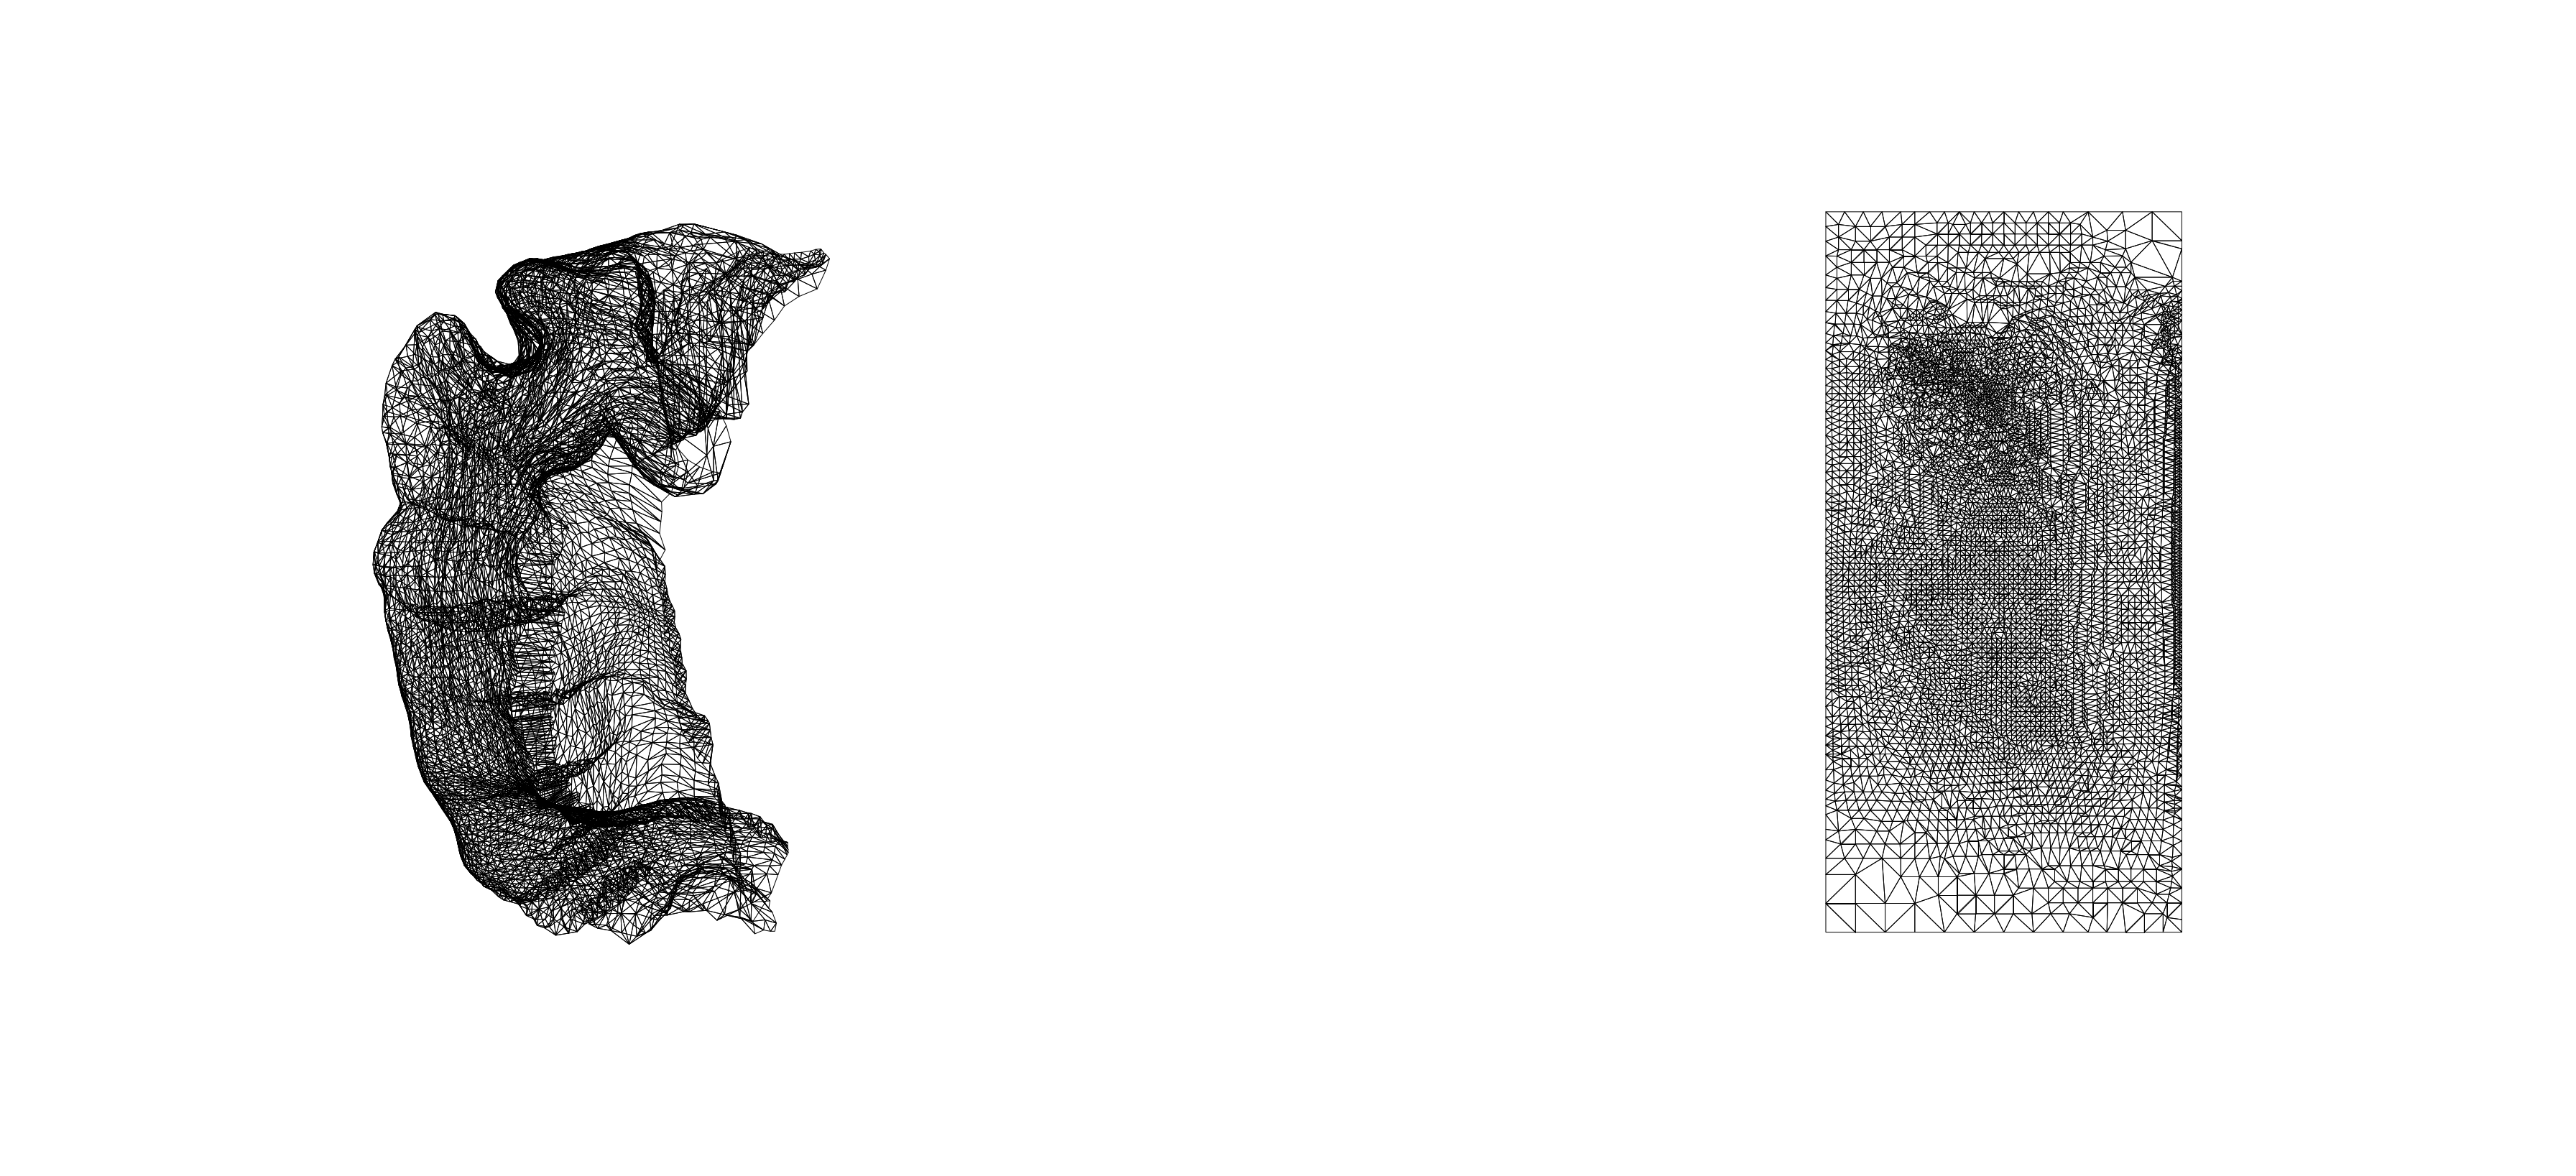

In [12]:
den='0p5mm'
gii = nib.load('/host/cassio/export03/data/unfolded_registration/hippunfold_v1.3.0_100um/hippunfold/sub-bbhist/surf/sub-bbhist_hemi-L_space-corobl_den-0p5mm_label-hipp_midthickness.surf.gii')
v = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
f = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
gii = nib.load(f'{resourcesdir}/canonical_surfs/tpl-avg_space-unfold_den-{den}_label-hipp_midthickness.surf.gii')
vu = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
gii = nib.load(f'{resourcesdir}/canonical_surfs/tpl-avg_space-unfold_den-{den}_label-dentate_midthickness.surf.gii')

# reorient unfolded
vu = vu[:,[1,0,2]]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(64,64), subplot_kw={'projection': "3d"})
plotwire(ax[0],f,v)
plotwire(ax[1],f,vu)